# Clustering Analysis -  Hierarchical Clustering
The only parameter s to consider is the **similarity function** and the **merging strategy** to form the hierarchy. The merging strategy here involves to compute the proximity matrix: the strategy must be able to merge cloud of points (*inside the two given cluster*),
determining the criteria for which those two cluster are closer or farest from each other. 


#### Task
1. Choose one state in the dataset and compare different clustering results got by using different version of
the algorithm
2. We can explore if some regions or states have similar incidents characteristics.

In [271]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)


In [272]:
df_merged_clustering = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5')

In [273]:
df_merged_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64        

In [274]:
cols_for_clustering =[ 
                        'percentage_injured', 
                        'unharmed_ratio', 
                        'males_to_females_ratio',
                        'povertyPercentage',
                        'avg_age_participants',
                        'density_incident_state',
                        'congressional_district',
                        #'ratio_killed',
                        'avg_incident_density_per_district'
                     ]


Pre-processing

In [275]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [276]:
import pandas as pd
violent_incidents_by_state = df_merged_clustering.groupby('state').size()
state_with_most_violence = violent_incidents_by_state.idxmax()
print(f"The state with the most record is: {state_with_most_violence}")


The state with the most record is: Illinois


In [277]:
#New index
df_merged_clustering['avg_incident_density_per_district'] = df_merged_clustering.groupby('congressional_district')['density_incident_state'].transform('sum') #avg


In [278]:
df_ill = df_merged_clustering[df_merged_clustering['state']=='Illinois']

#df_ill = df_ill[cols_for_clustering]
df_ill_clustering = df_ill[cols_for_clustering]
#df_ill_clustering['death_level'] = df_ill_clustering['death_level'].map({'No deaths': 0, 'Some deaths': 1, 'All deaths': 2})

In [279]:
state_dataset_dim = len(df_ill_clustering)

In [280]:
scaler = MinMaxScaler()
df_ill_scaled = scaler.fit_transform(df_ill_clustering)


In [281]:
#pca
pca = PCA(n_components=2)
df_ill_pca = pca.fit_transform(df_ill_scaled)


In [282]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

cluster_results = {}  # Global dictionary to store results

def cluster_and_analyze(data, metric, linkage, n_clusters):
    global cluster_results
    
    # Perform Agglomerative Clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
    clusters = clustering.fit_predict(data)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(data, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
    
    # Compute size of each cluster
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
    for cluster_id, cluster_count in zip(unique_clusters, cluster_counts):
        print(f"Cluster {cluster_id}: Size {cluster_count}")
    
    # Store results in global dictionary
    result_key = (metric, linkage)
    cluster_results[result_key] = (n_clusters, silhouette_avg)
    
    return clusters, silhouette_avg, n_clusters

# Hierachical Clustering
There are 2 kinds of hierarchical clustering: agglomerative and divisive. 
In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. 

The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. There are 2 parameters: the method, that can be `single, complete, ward, average, weighted, centroids` and `median`, and the metric used to compute the distances, such as `euclidean` or `cosine`. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.

In [283]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np

random_indices = np.random.choice(df_ill_scaled.shape[0], state_dataset_dim, replace=False)
subset_data = df_ill_scaled[random_indices]

In [284]:
subset_data

array([[0.        , 0.98666255, 0.25      , ..., 0.        , 0.05882353,
        0.76967056],
       [0.        , 1.        , 0.5       , ..., 0.        , 0.23529412,
        0.34389019],
       [0.        , 0.        , 0.25      , ..., 0.        , 0.35294118,
        0.98159707],
       ...,
       [0.        , 1.        , 0.5       , ..., 0.        , 0.23529412,
        0.34389019],
       [0.        , 0.63100115, 0.5       , ..., 0.        , 0.17647059,
        0.48590865],
       [0.        , 1.        , 0.5       , ..., 0.        , 0.35294118,
        0.98159707]])

Silhouette Score: 0.24481433250713194
Cluster 0: Size 4148
Cluster 1: Size 2212
Cluster 2: Size 6726


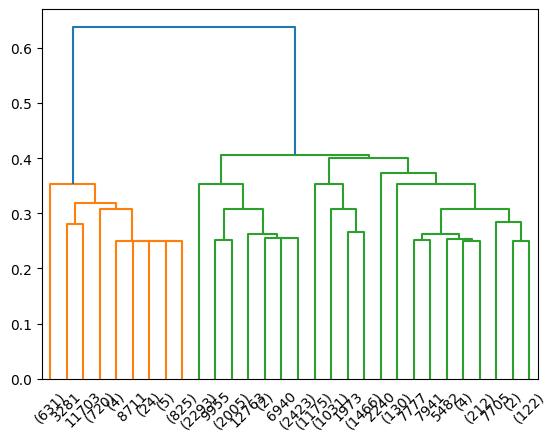

In [285]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'euclidean', 'single', 3)

Silhouette Score: 0.24481433250713194
Cluster 0: Size 2212
Cluster 1: Size 4148
Cluster 2: Size 6726


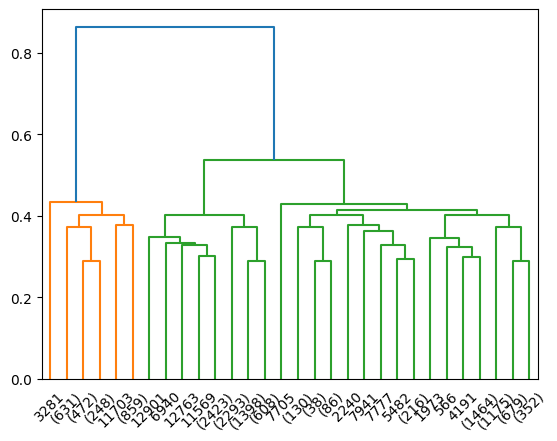

In [286]:
data_dist = pdist(subset_data, metric='cityblock')
data_link = linkage(data_dist, method='single', metric='manhattan')
res = dendrogram(data_link, truncate_mode='lastp')
cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'manhattan', 'single', 3)

Silhouette Score: 0.3041819048116275
Cluster 0: Size 1798
Cluster 1: Size 546
Cluster 2: Size 7327
Cluster 3: Size 2117
Cluster 4: Size 1298


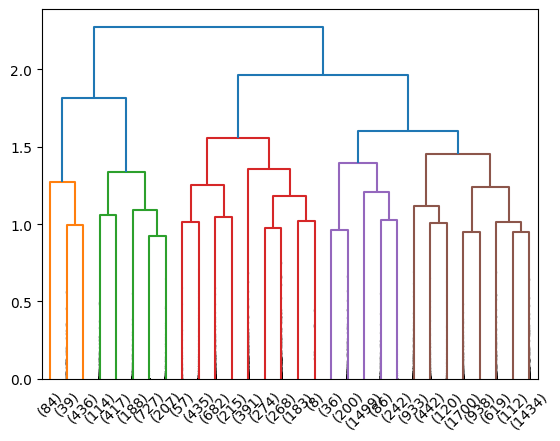

In [287]:

# Compute pairwise distances and perform clustering on the subset
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp', show_contracted=True)

cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'euclidean', 'complete', 5)

Silhouette Score: 0.41748068962169016
Cluster 0: Size 8354
Cluster 1: Size 2520
Cluster 2: Size 2212


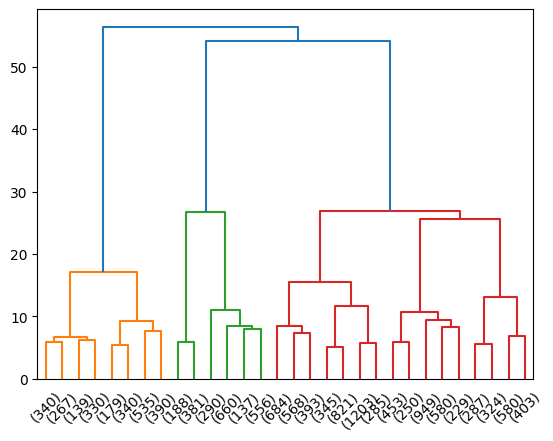

In [288]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'euclidean', 'ward', 3)

Silhouette Score: 0.35779646279560184
Cluster 0: Size 2
Cluster 1: Size 2514
Cluster 2: Size 8354
Cluster 3: Size 567
Cluster 4: Size 1643
Cluster 5: Size 2
Cluster 6: Size 4


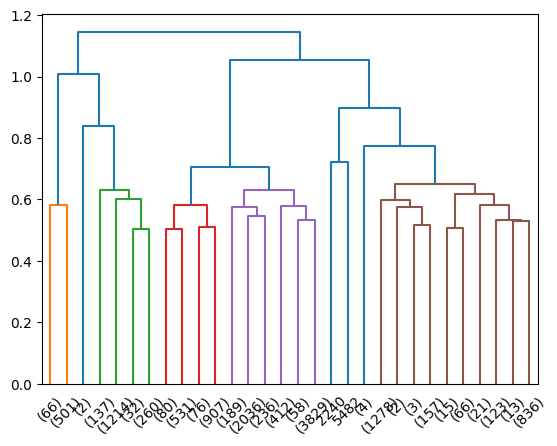

In [289]:
data_dist = pdist(subset_data, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp', color_threshold=0.7)
cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'euclidean', 'average', 7)

Silhouette Score: 0.41719241597532114
Cluster 0: Size 2212
Cluster 1: Size 2514
Cluster 2: Size 8360


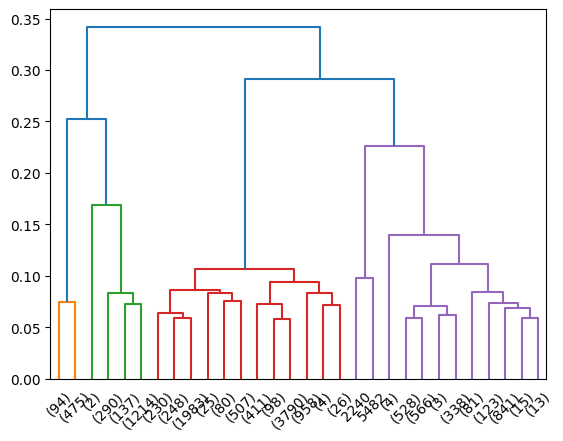

In [290]:
data_dist = pdist(subset_data, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, truncate_mode='lastp')
cluster_labels, silhouette, clusters = cluster_and_analyze(df_ill_scaled, 'cosine', 'average', 3)

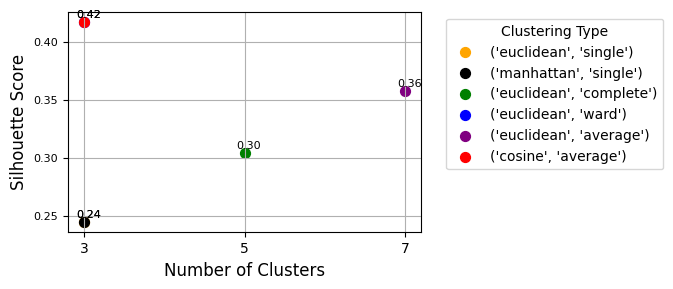

In [291]:
import matplotlib.pyplot as plt

# Assuming cluster_results contains the data you want to plot

# Extracting data for plotting
metrics_linkages = list(cluster_results.keys())
silhouette_scores = [cluster_results[key][1] for key in metrics_linkages]
num_clusters = [cluster_results[key][0] for key in metrics_linkages]

# Create a color map for different types of clustering
color_map = {
    ('euclidean', 'ward'): 'blue',
    ('euclidean', 'complete'): 'green',
    ('cosine', 'average'): 'red',
    ('euclidean', 'average'): 'purple',
    ('euclidean', 'single'): 'orange',
    ('manhattan', 'single'): 'black'
    # Add more colors and mappings for other combinations if needed
}

# Extracting colors based on the clustering type
colors = [color_map[key] for key in metrics_linkages]

# Creating the plot with compactness and adjusted font size
plt.figure(figsize=(7, 3))  # Adjusted figure size
for i in range(len(metrics_linkages)):
    plt.scatter(num_clusters[i], silhouette_scores[i], s=50, c=colors[i], label=str(metrics_linkages[i]))  # Reduced marker size
    plt.annotate(f"{silhouette_scores[i]:.2f}", (num_clusters[i], silhouette_scores[i]), textcoords="offset points", xytext=(3,3), ha='center', fontsize=8)  # Adjusted text font size

plt.xlabel('Number of Clusters', fontsize=12)  # Adjusted font size for axis labels
plt.ylabel('Silhouette Score', fontsize=12)  # Adjusted font size for axis labels
plt.xticks(list(set(num_clusters)), fontsize=10)  # Adjusted font size for x-axis ticks
plt.yticks(fontsize=8)  # Adjusted font size for y-axis ticks
plt.legend(title='Clustering Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  # Adjusted font size for legend
plt.grid(True)
plt.autoscale()  # Adjust axes scale based on data
plt.tight_layout()  # Ensures tight layout to reduce whitespace
plt.show()


In [292]:
cluster_ward = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster_ward.fit_predict(df_ill_scaled)
df_ill_clustering['cluster_ward'] = cluster_ward.labels_
df_ill_clustering['cluster_ward'].value_counts()
#db = round(davies_bouldin_score(X, labels), 2)



/tmp/ipykernel_126615/146686760.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_ward
0    8354
1    2520
2    2212
Name: count, dtype: int64

In [293]:
cluster_single = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='single')
cluster_single.fit_predict(df_ill_scaled)
df_ill_clustering['cluster_single'] = cluster_single.labels_
df_ill_clustering['cluster_single'].value_counts()

/tmp/ipykernel_126615/1110454779.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_single
2    6726
0    4148
1    2212
Name: count, dtype: int64

In [294]:
cluster_single = AgglomerativeClustering(n_clusters=4, metric='manhattan', linkage='single')
cluster_single.fit_predict(df_ill_scaled)
df_ill_clustering['cluster_manhattan'] = cluster_single.labels_
df_ill_clustering['cluster_manhattan'].value_counts()

/tmp/ipykernel_126615/2231389789.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_manhattan
2    6726
0    4148
1    2211
3       1
Name: count, dtype: int64

In [295]:
cluster_single = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='average')
cluster_single.fit_predict(df_ill_scaled)
df_ill_clustering['cluster_average'] = cluster_single.labels_
df_ill_clustering['cluster_average'].value_counts()

/tmp/ipykernel_126615/3235990743.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_average
2    8354
1    2514
4    1643
3     567
6       4
5       2
0       2
Name: count, dtype: int64

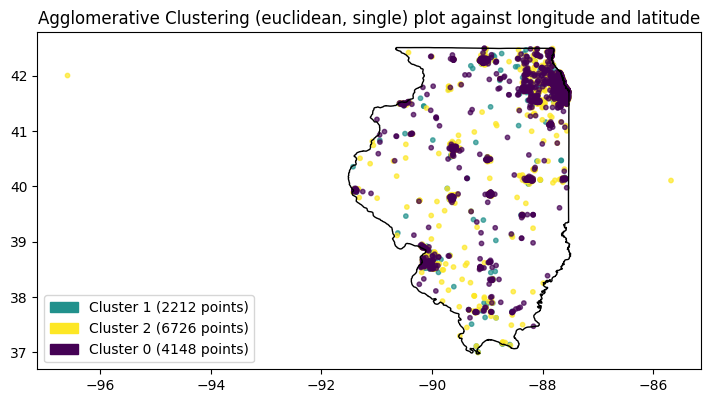

In [296]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/illinois_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_ill_clustering['cluster_single'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

# Normalize the colormap
norm = plt.Normalize(df_ill_clustering['cluster_single'].min(), df_ill_clustering['cluster_single'].max())

# Create a scatter plot
sc = plt.scatter(df_merged_clustering['longitude'][:13086], df_merged_clustering['latitude'][:13086],
                 c=df_ill_clustering['cluster_single'][:13086], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
illinois_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_ill_clustering['cluster_single'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('Agglomerative Clustering (euclidean, single) plot against longitude and latitude')
plt.tight_layout()
plt.show()


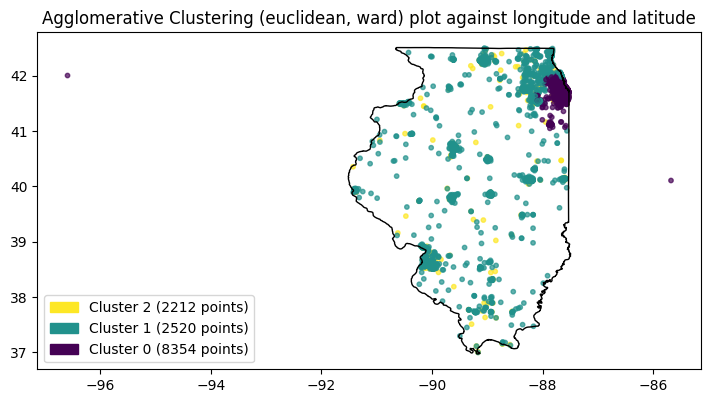

In [297]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/illinois_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_ill_clustering['cluster_ward'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

# Normalize the colormap
norm = plt.Normalize(df_ill_clustering['cluster_ward'].min(), df_ill_clustering['cluster_ward'].max())

# Create a scatter plot
sc = plt.scatter(df_merged_clustering['longitude'][:13086], df_merged_clustering['latitude'][:13086],
                 c=df_ill_clustering['cluster_ward'][:13086], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
illinois_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_ill_clustering['cluster_ward'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('Agglomerative Clustering (euclidean, ward) plot against longitude and latitude')
plt.tight_layout()
plt.show()


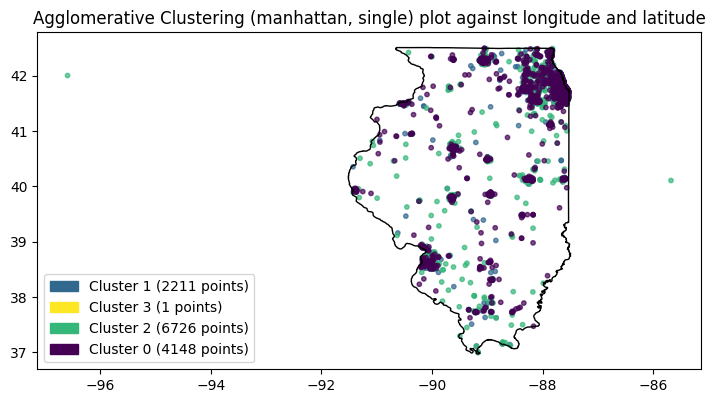

In [298]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/illinois_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_ill_clustering['cluster_manhattan'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

# Normalize the colormap
norm = plt.Normalize(df_ill_clustering['cluster_manhattan'].min(), df_ill_clustering['cluster_manhattan'].max())

# Create a scatter plot
sc = plt.scatter(df_merged_clustering['longitude'][:13086], df_merged_clustering['latitude'][:13086],
                 c=df_ill_clustering['cluster_manhattan'][:13086], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
illinois_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_ill_clustering['cluster_manhattan'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('Agglomerative Clustering (manhattan, single) plot against longitude and latitude')
plt.tight_layout()
plt.show()


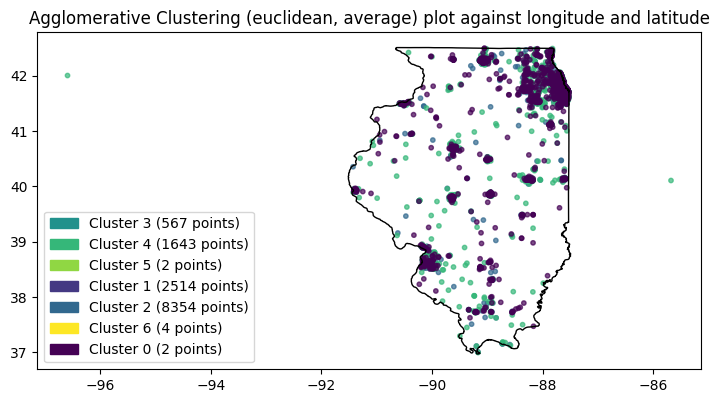

In [299]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/illinois_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_ill_clustering['cluster_average'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

# Normalize the colormap
norm = plt.Normalize(df_ill_clustering['cluster_average'].min(), df_ill_clustering['cluster_average'].max())

# Create a scatter plot
sc = plt.scatter(df_merged_clustering['longitude'][:13086], df_merged_clustering['latitude'][:13086],
                 c=df_ill_clustering['cluster_manhattan'][:13086], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
illinois_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_ill_clustering['cluster_average'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('Agglomerative Clustering (euclidean, average) plot against longitude and latitude')
plt.tight_layout()
plt.show()


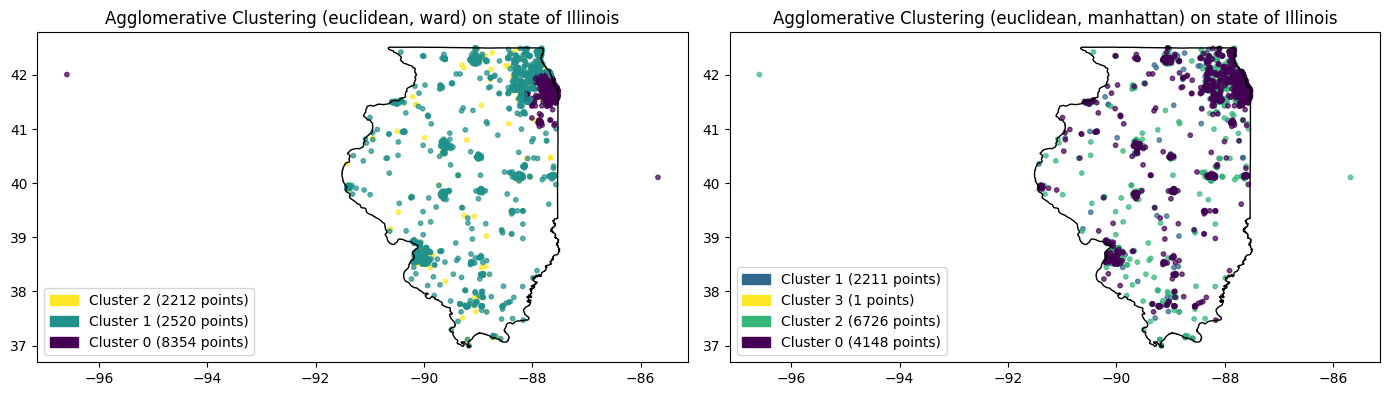

In [300]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the shapefile of Illinois
illinois_shapefile = '../../map_data/illinois_shape.shp'
illinois_map = gpd.read_file(illinois_shapefile)

# Initialize a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clustering method: ward
clusters_ward = df_ill_clustering['cluster_ward'].unique()
cmap_ward = plt.cm.viridis
norm_ward = plt.Normalize(df_ill_clustering['cluster_ward'].min(), df_ill_clustering['cluster_ward'].max())

# Restrict only to Illinois state for ward clustering
df_merged_ward = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

sc_ward = axes[0].scatter(df_merged_ward['longitude'][:13086], df_merged_ward['latitude'][:13086],
                           c=df_ill_clustering['cluster_ward'][:13086], cmap='viridis', s=10, alpha=0.7)

illinois_map.plot(ax=axes[0], color='none', edgecolor='black')

cluster_sizes_ward = df_ill_clustering['cluster_ward'].value_counts()
patches_ward = [mpatches.Patch(color=cmap_ward(norm_ward(cluster)), 
                               label=f'Cluster {cluster} ({cluster_sizes_ward[cluster]} points)') for cluster in clusters_ward]

axes[0].legend(handles=patches_ward)
axes[0].set_title('Agglomerative Clustering (euclidean, ward) on state of Illinois')

# Clustering method: single
clusters_single = df_ill_clustering['cluster_manhattan'].unique()
cmap_single = plt.cm.viridis
norm_single = plt.Normalize(df_ill_clustering['cluster_manhattan'].min(), df_ill_clustering['cluster_manhattan'].max())

# Restrict only to Illinois state for single clustering
df_merged_single = df_merged_clustering[df_merged_clustering['state'] == 'Illinois']

sc_single = axes[1].scatter(df_merged_single['longitude'][:13086], df_merged_single['latitude'][:13086],
                             c=df_ill_clustering['cluster_manhattan'][:13086], cmap='viridis', s=10, alpha=0.7)

illinois_map.plot(ax=axes[1], color='none', edgecolor='black')

cluster_sizes_single = df_ill_clustering['cluster_manhattan'].value_counts()
patches_single = [mpatches.Patch(color=cmap_single(norm_single(cluster)), 
                                  label=f'Cluster {cluster} ({cluster_sizes_single[cluster]} points)') for cluster in clusters_single]

axes[1].legend(handles=patches_single)
axes[1].set_title('Agglomerative Clustering (euclidean, manhattan) on state of Illinois')

plt.tight_layout()
plt.show()


In [301]:
df_merged_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13086 entries, 93 to 134539
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   date                               13086 non-null  datetime64[ns]
 1   state                              13086 non-null  object        
 2   city_or_county                     13086 non-null  object        
 3   latitude                           13086 non-null  float64       
 4   longitude                          13086 non-null  float64       
 5   congressional_district             13086 non-null  int64         
 6   participant_age_group1             13086 non-null  category      
 7   participant_gender1                13086 non-null  category      
 8   avg_age_participants               13086 non-null  int64         
 9   n_participants_child               13086 non-null  int64         
 10  n_participants_teen                13

In [302]:
df_merged_clustering['cluster_ward'] = df_ill_clustering['cluster_ward']
df_merged_clustering['cluster_single'] = df_ill_clustering['cluster_single']
df_merged_clustering['cluster_manhattan'] = df_ill_clustering['cluster_manhattan']
df_merged_clustering['cluster_average'] = df_ill_clustering['cluster_average']

<Axes: xlabel='cluster_ward', ylabel='count'>

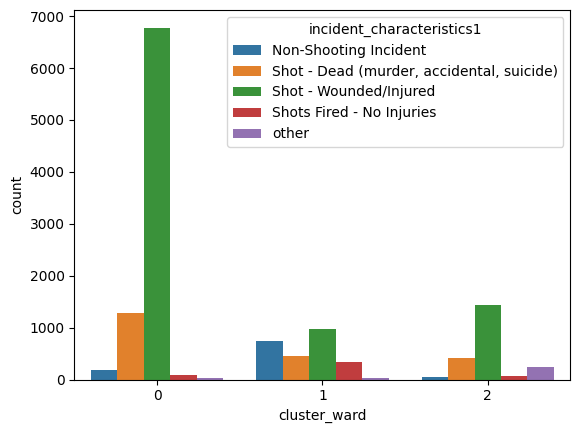

In [303]:
# Let's see the distribution of the feature 'incident_characteristics1' in the 4 clusters
sns.countplot(data=df_merged_clustering, x='cluster_ward', hue='incident_characteristics1')

<Axes: xlabel='cluster_single', ylabel='count'>

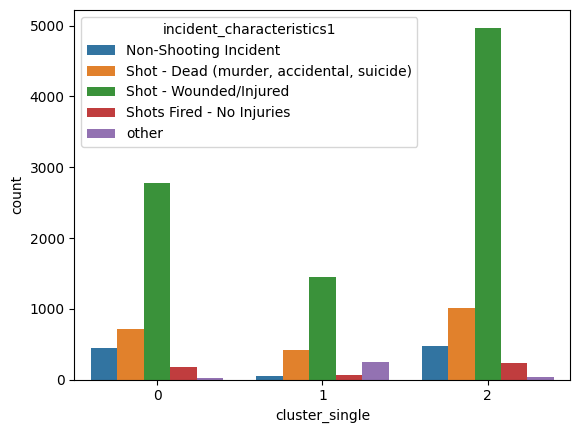

In [304]:
sns.countplot(data=df_merged_clustering, x='cluster_single', hue='incident_characteristics1')

<Axes: xlabel='cluster_manhattan', ylabel='count'>

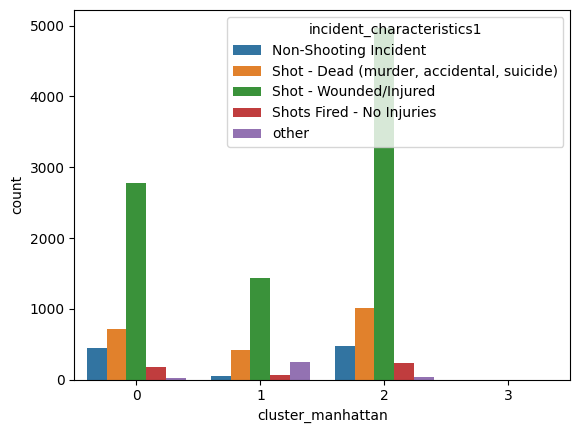

In [305]:
sns.countplot(data=df_merged_clustering, x='cluster_manhattan', hue='incident_characteristics1')

<Axes: xlabel='cluster_average', ylabel='count'>

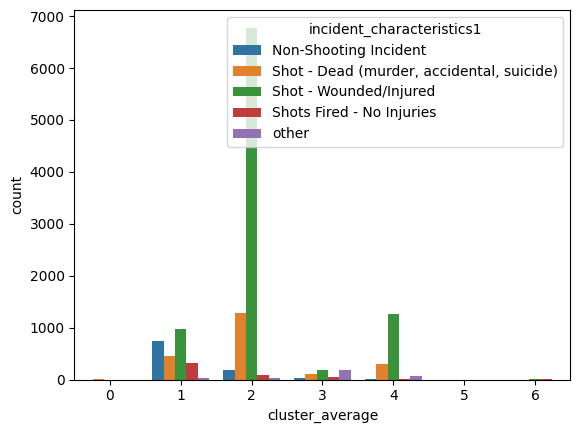

In [306]:
sns.countplot(data=df_merged_clustering, x='cluster_average', hue='incident_characteristics1')

<Axes: xlabel='cluster_ward', ylabel='count'>

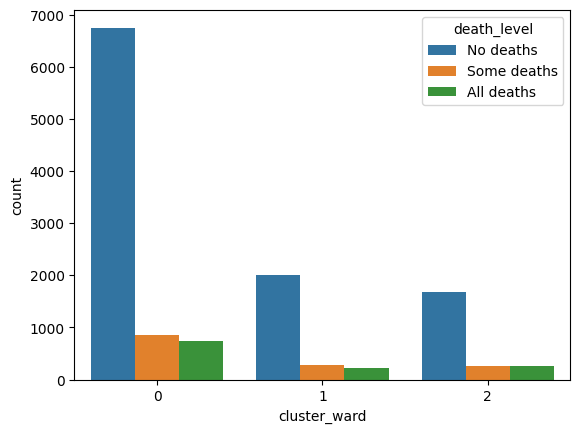

In [307]:
sns.countplot(data=df_merged_clustering, x='cluster_ward', hue='death_level')

<Axes: xlabel='cluster_single', ylabel='count'>

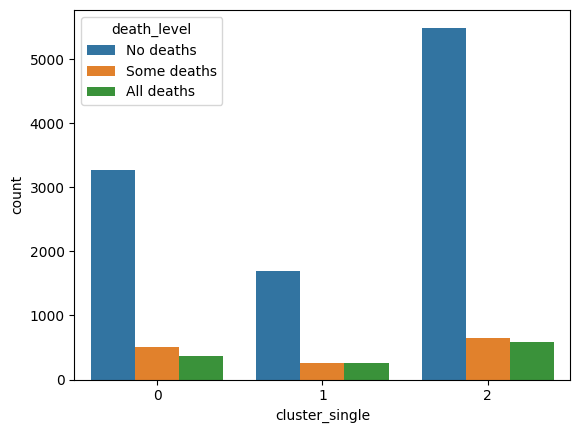

In [308]:
sns.countplot(data=df_merged_clustering, x='cluster_single', hue='death_level')

<Axes: xlabel='cluster_manhattan', ylabel='count'>

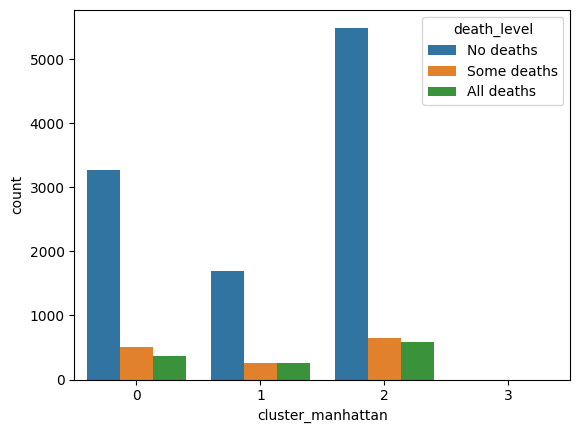

In [309]:
sns.countplot(data=df_merged_clustering, x='cluster_manhattan', hue='death_level')

<Axes: xlabel='cluster_average', ylabel='count'>

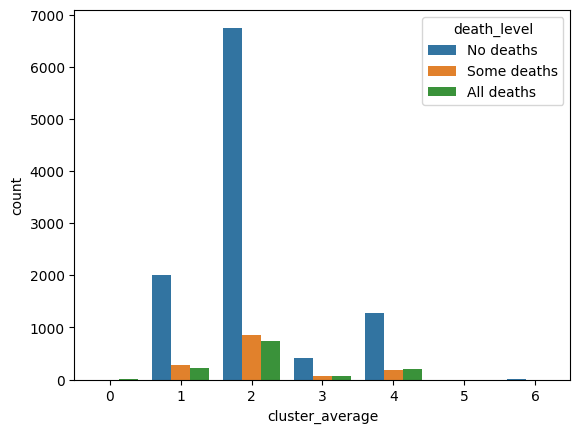

In [310]:
sns.countplot(data=df_merged_clustering, x='cluster_average', hue='death_level')